**1. Importing Necessary packages**

In [48]:
import pandas as pd
from pathlib import Path
import cv2
from PIL import Image
from random import randint
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from zipfile import ZipFile
import tensorflow.keras.optimizers as Optimizer
import tensorflow.keras.layers as Layers
import tensorflow.keras.models as Models
from sklearn.model_selection import train_test_split
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Dense, Conv2D, Activation, Dropout, Flatten, MaxPooling2D
from keras.models import Sequential, load_model, Model
import matplotlib.gridspec as gridspec
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sn
import tensorflow as tf
from tensorflow.keras import optimizers

**2. Defined function**

2.1 Data Fnctions

In [ ]:
# function to read images
def read_images(dataset_dir, image_directories):
    images=[]
    classes =[]
    if len(image_directories)!=0:
      for img_dir in image_directories:
          for path in Path(dataset_dir+'/'+img_dir).iterdir():
              if path.name.endswith('.jpg'):
                      img = cv2.imread(str(path))
                      img = cv2.resize(img,(150,150))  #Resize the image, Some images are different sizes.
                      images.append(img)
                      classes.append(img_dir)
    elif len(image_directories) == 0:
      for path in Path(dataset_dir).iterdir():
              if path.name.endswith('.jpg'):
                      img = cv2.imread(str(path))
                      img = cv2.resize(img,(150,150))  #Resize the image, Some images are different sizes.
                      images.append(img)
    return images, classes


#function to display images
def display_images(images, classes, rows, columns):
    plt.subplots_adjust(0,0,3,3)
    for i in range(0,rows*columns):
        random_number = randint(0, len(train_images))
        img = images[random_number]
        plt.subplot(rows,columns,i+1)
        plt.title(classes[random_number])
        plt.axis('off')
        plt.imshow(img)

2.2 Util functions


In [ ]:
# My label encoder
def my_label_encoder(classes):
  class_dict ={'buildings':0, 'forest':1, 'glacier':2, 'mountain':3, 'sea':4, 'street':5}
  labels = [class_dict[item] for item in classes]
  return labels

def my_label_decoder(class_code):
    labels = {2:'glacier', 4:'sea', 0:'buildings', 1:'forest', 5:'street', 3:'mountain', 6:'unknown'}
    return labels[class_code]

# Unzip files
def unzipfile(zipfile):
  with ZipFile(zipfile, 'r') as zipObj:
    zipObj.extractall()



2.3 Model functions

In [ ]:
#set early stopping criteria
pat = 2 #this is the number of epochs with no improvment after which the training will stop
early_stopping = EarlyStopping(monitor='val_loss', patience=pat, verbose=1)

#define the model checkpoint callback -> this will keep on saving the model as a physical file
model_checkpoint = ModelCheckpoint('fas_mnist_1.h5', verbose=1, save_best_only=True)


#Function for cross validation
def n_fold_cross_validator(n_folds, X, y, model):
  model_history = []
  for i in range(n_folds):
      print("Training on Fold: ",i+1)
      # X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=test_size, random_state = np.random.randint(1,1000, 1)[0])
      # evaluate model
      model_history.append(model.fit(X, y, epochs=20, callbacks=[early_stopping],
              verbose=1, validation_split=0.1))
      print("======="*12, end="\n\n\n")

  return model_history

**3. Reading Visualization of Training Images**

In [3]:
# Variables used in this task
image_directories = ['buildings','forest','glacier','mountain','sea','street']
train_directory = 'seg_train'

In [4]:
# unzipping training file
unzipfile('seg_train.zip')

In [5]:
# Reading images in training set
train_images, train_classes = read_images('./seg_train', image_directories)

In [6]:
# convert list of images to numpy array
train_images = np.array(train_images)
train_classes = np.array(train_classes)

In [7]:
# We will check shape of images and labels
print('Shape of Images:', train_images.shape)
print('Shape of Classes:', train_classes.shape)

Shape of Images: (14034, 150, 150, 3)
Shape of Classes: (14034,)


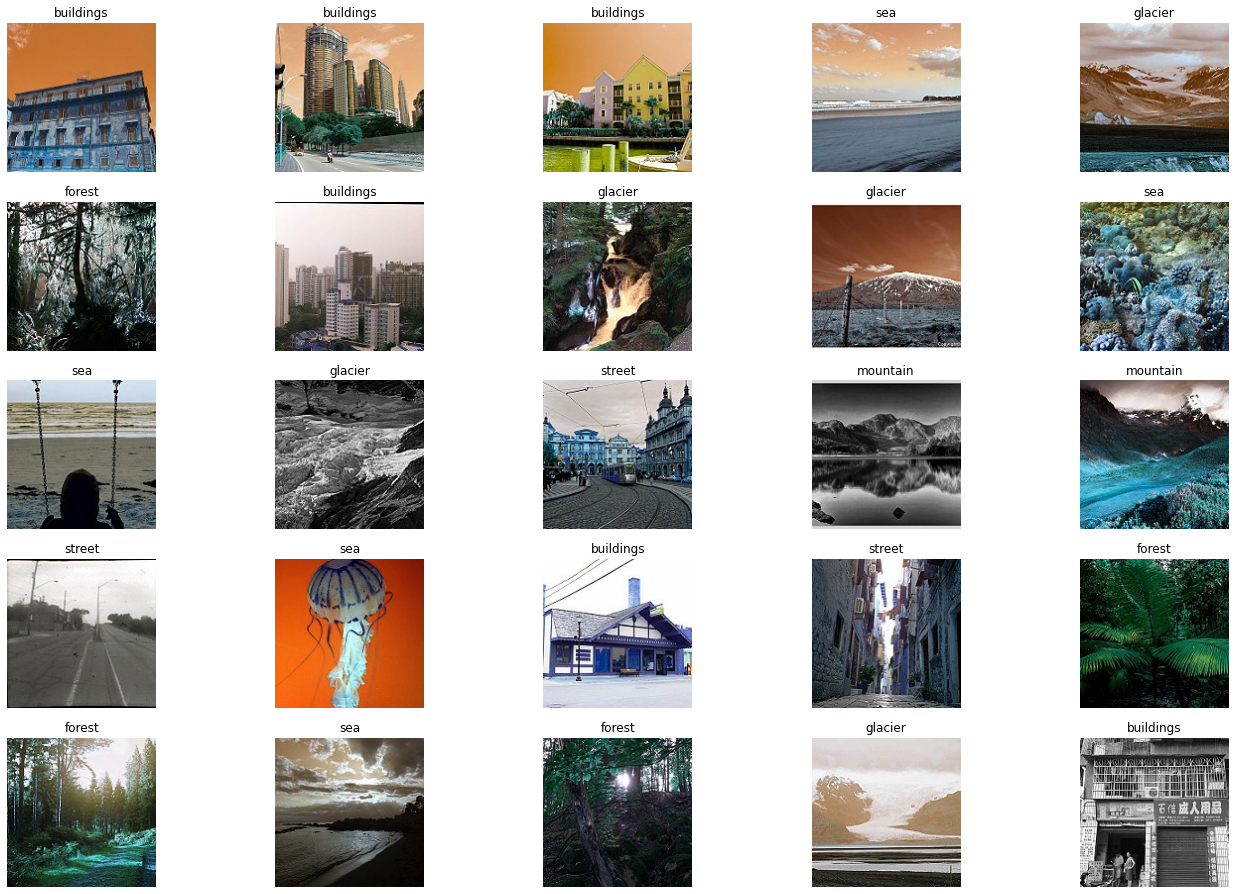

In [8]:
# Display 25 random images from training set
display_images(train_images, train_classes, 5, 5)

**4. Developing CNN model**

In [9]:
train_labels = my_label_encoder(train_classes)
train_labels = np.array(train_labels)

In [10]:
# Developing CNN model for Image classification
model=Models.Sequential()

model.add(Layers.Conv2D(200,kernel_size=(3,3),activation='relu',input_shape=(150,150,3)))
model.add(Layers.Conv2D(180,kernel_size=(3,3),activation='relu'))
model.add(Layers.MaxPool2D(5,5))
model.add(Layers.Conv2D(180,kernel_size=(3,3),activation='relu'))
model.add(Layers.Conv2D(140,kernel_size=(3,3),activation='relu'))
model.add(Layers.Conv2D(100,kernel_size=(3,3),activation='relu'))
model.add(Layers.Conv2D(50,kernel_size=(3,3),activation='relu'))
model.add(Layers.MaxPool2D(5,5))
model.add(Layers.Flatten())
model.add(Layers.Dense(180,activation='relu'))
model.add(Layers.Dense(100,activation='relu'))
model.add(Layers.Dense(50,activation='relu'))
model.add(Layers.Dropout(rate=0.5))
model.add(Layers.Dense(6,activation='softmax'))

model.compile(optimizer=Optimizer.Adam(learning_rate=0.0001),loss='sparse_categorical_crossentropy',metrics=['accuracy'])


In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 200)     5600      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 146, 146, 180)     324180    
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 29, 29, 180)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 27, 27, 180)       291780    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 25, 25, 140)       226940    
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 23, 23, 100)       126100    
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 21, 21, 50)        4

**5. Validating CNN model**

5.1 10-fold cross validation


In [15]:
#10 fold cross validation
model_history = n_fold_cross_validator(10, train_images, train_labels, model)

Training on Fold:  1
Epoch 1/20
395/395 [==============================] - 130s 236ms/step - loss: 1.7019 - accuracy: 0.3443 - val_loss: 1.9045 - val_accuracy: 0.0997
Epoch 2/20
395/395 [==============================] - 90s 228ms/step - loss: 1.1643 - accuracy: 0.5522 - val_loss: 1.2237 - val_accuracy: 0.4131
Epoch 3/20
395/395 [==============================] - 91s 231ms/step - loss: 0.9530 - accuracy: 0.6515 - val_loss: 1.5259 - val_accuracy: 0.5484
Epoch 4/20
395/395 [==============================] - 92s 234ms/step - loss: 0.8553 - accuracy: 0.7001 - val_loss: 0.8807 - val_accuracy: 0.6766
Epoch 5/20
395/395 [==============================] - 93s 235ms/step - loss: 0.7504 - accuracy: 0.7364 - val_loss: 0.9926 - val_accuracy: 0.6090
Epoch 6/20
395/395 [==============================] - 93s 235ms/step - loss: 0.6694 - accuracy: 0.7663 - val_loss: 1.2653 - val_accuracy: 0.5335
Epoch 00006: early stopping


Training on Fold:  2
Epoch 1/20
395/395 [==============================] - 93s

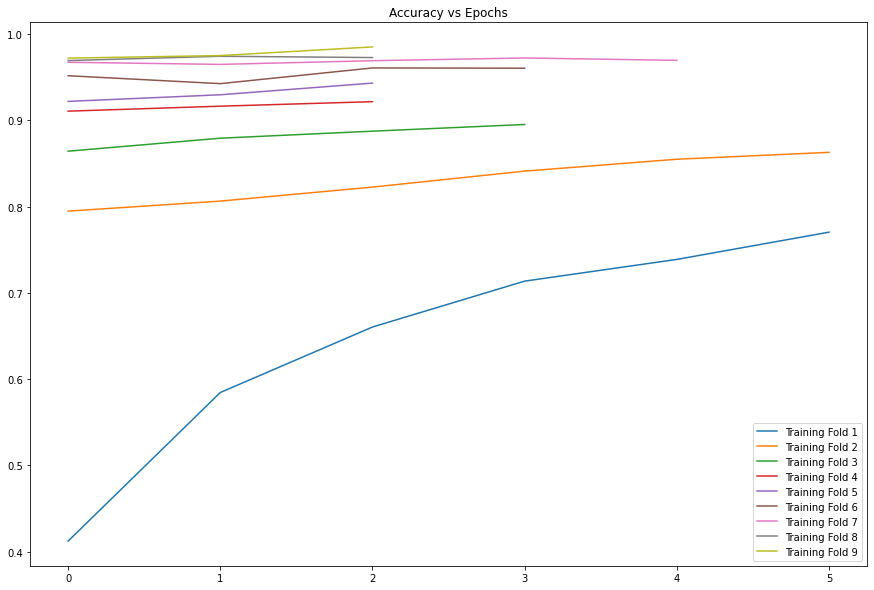

In [16]:
plt.figure(figsize=(15,10))
plt.title('Accuracy vs Epochs')
# plot_labels = 'Training Fold ' + i+1
for i in range(0,9):
  plt.plot(model_history[i].history['accuracy'], label='Training Fold '+str(i+1))

plt.legend() 
plt.show()

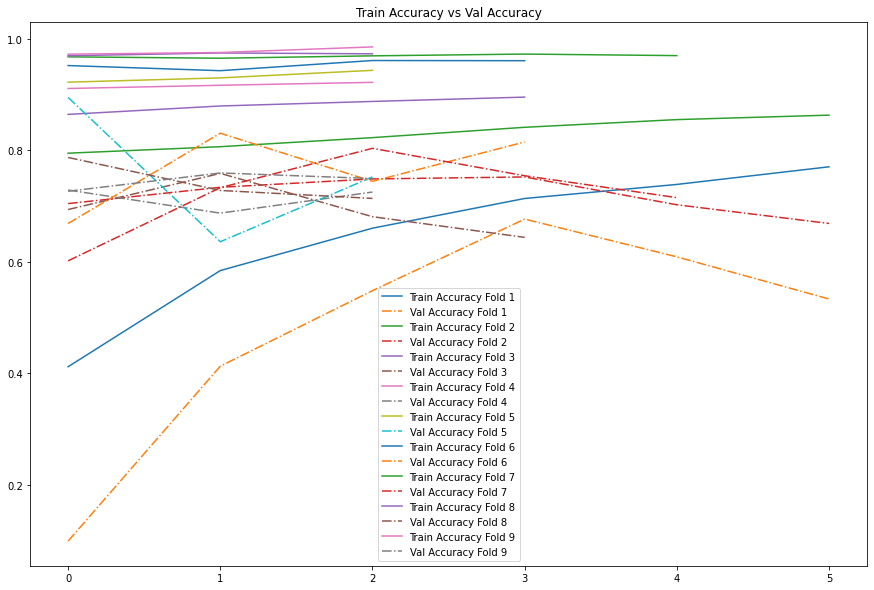

In [17]:
plt.figure(figsize=(15,10))
plt.title('Train Accuracy vs Val Accuracy')
for i in range(0,9):
  plt.plot(model_history[i].history['accuracy'], label='Train Accuracy Fold '+str(i+1))
  plt.plot(model_history[i].history['val_accuracy'], label='Val Accuracy Fold '+str(i+1), linestyle = "dashdot")
plt.legend()
plt.show()

5.2 Validation with test data

In [19]:
# Now let us check model accuracy with test data

# Read test images and labels
unzipfile('seg_test.zip')
test_images, test_classes= read_images('./seg_test', image_directories)

In [20]:
# convert test  images to numpy array
test_images = np.array(test_images)
test_classes = np.array(test_classes)

In [21]:
# We will check shape of images and labels
print('Shape of Images:', test_images.shape)
print('Shape of Classes:', test_classes.shape)

Shape of Images: (3000, 150, 150, 3)
Shape of Classes: (3000,)


In [22]:
# Label encoding for test classes
test_labels = my_label_encoder(test_classes)
test_labels = np.array(test_labels)

In [23]:
# #Load the model that was saved by ModelCheckpoint
# model = load_model('fas_mnist_1.h5')

In [24]:
model.evaluate(test_images, test_labels)

94/94 [==============================] - 9s 94ms/step - loss: 1.1157 - accuracy: 0.8473


[1.1156854629516602, 0.8473333120346069]

**6. Predciting the labels for new images**

In [26]:
# Read Prediction images
unzipfile('seg_pred.zip')
pred_images, no_labels = read_images('./seg_pred', [])

In [27]:
pred_images = np.array(pred_images)
pred_images.shape

(7301, 150, 150, 3)

In [28]:
def get_classlabel(class_code):
    labels = {2:'glacier', 4:'sea', 0:'buildings', 1:'forest', 5:'street', 3:'mountain'}
    
    return labels[class_code]

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


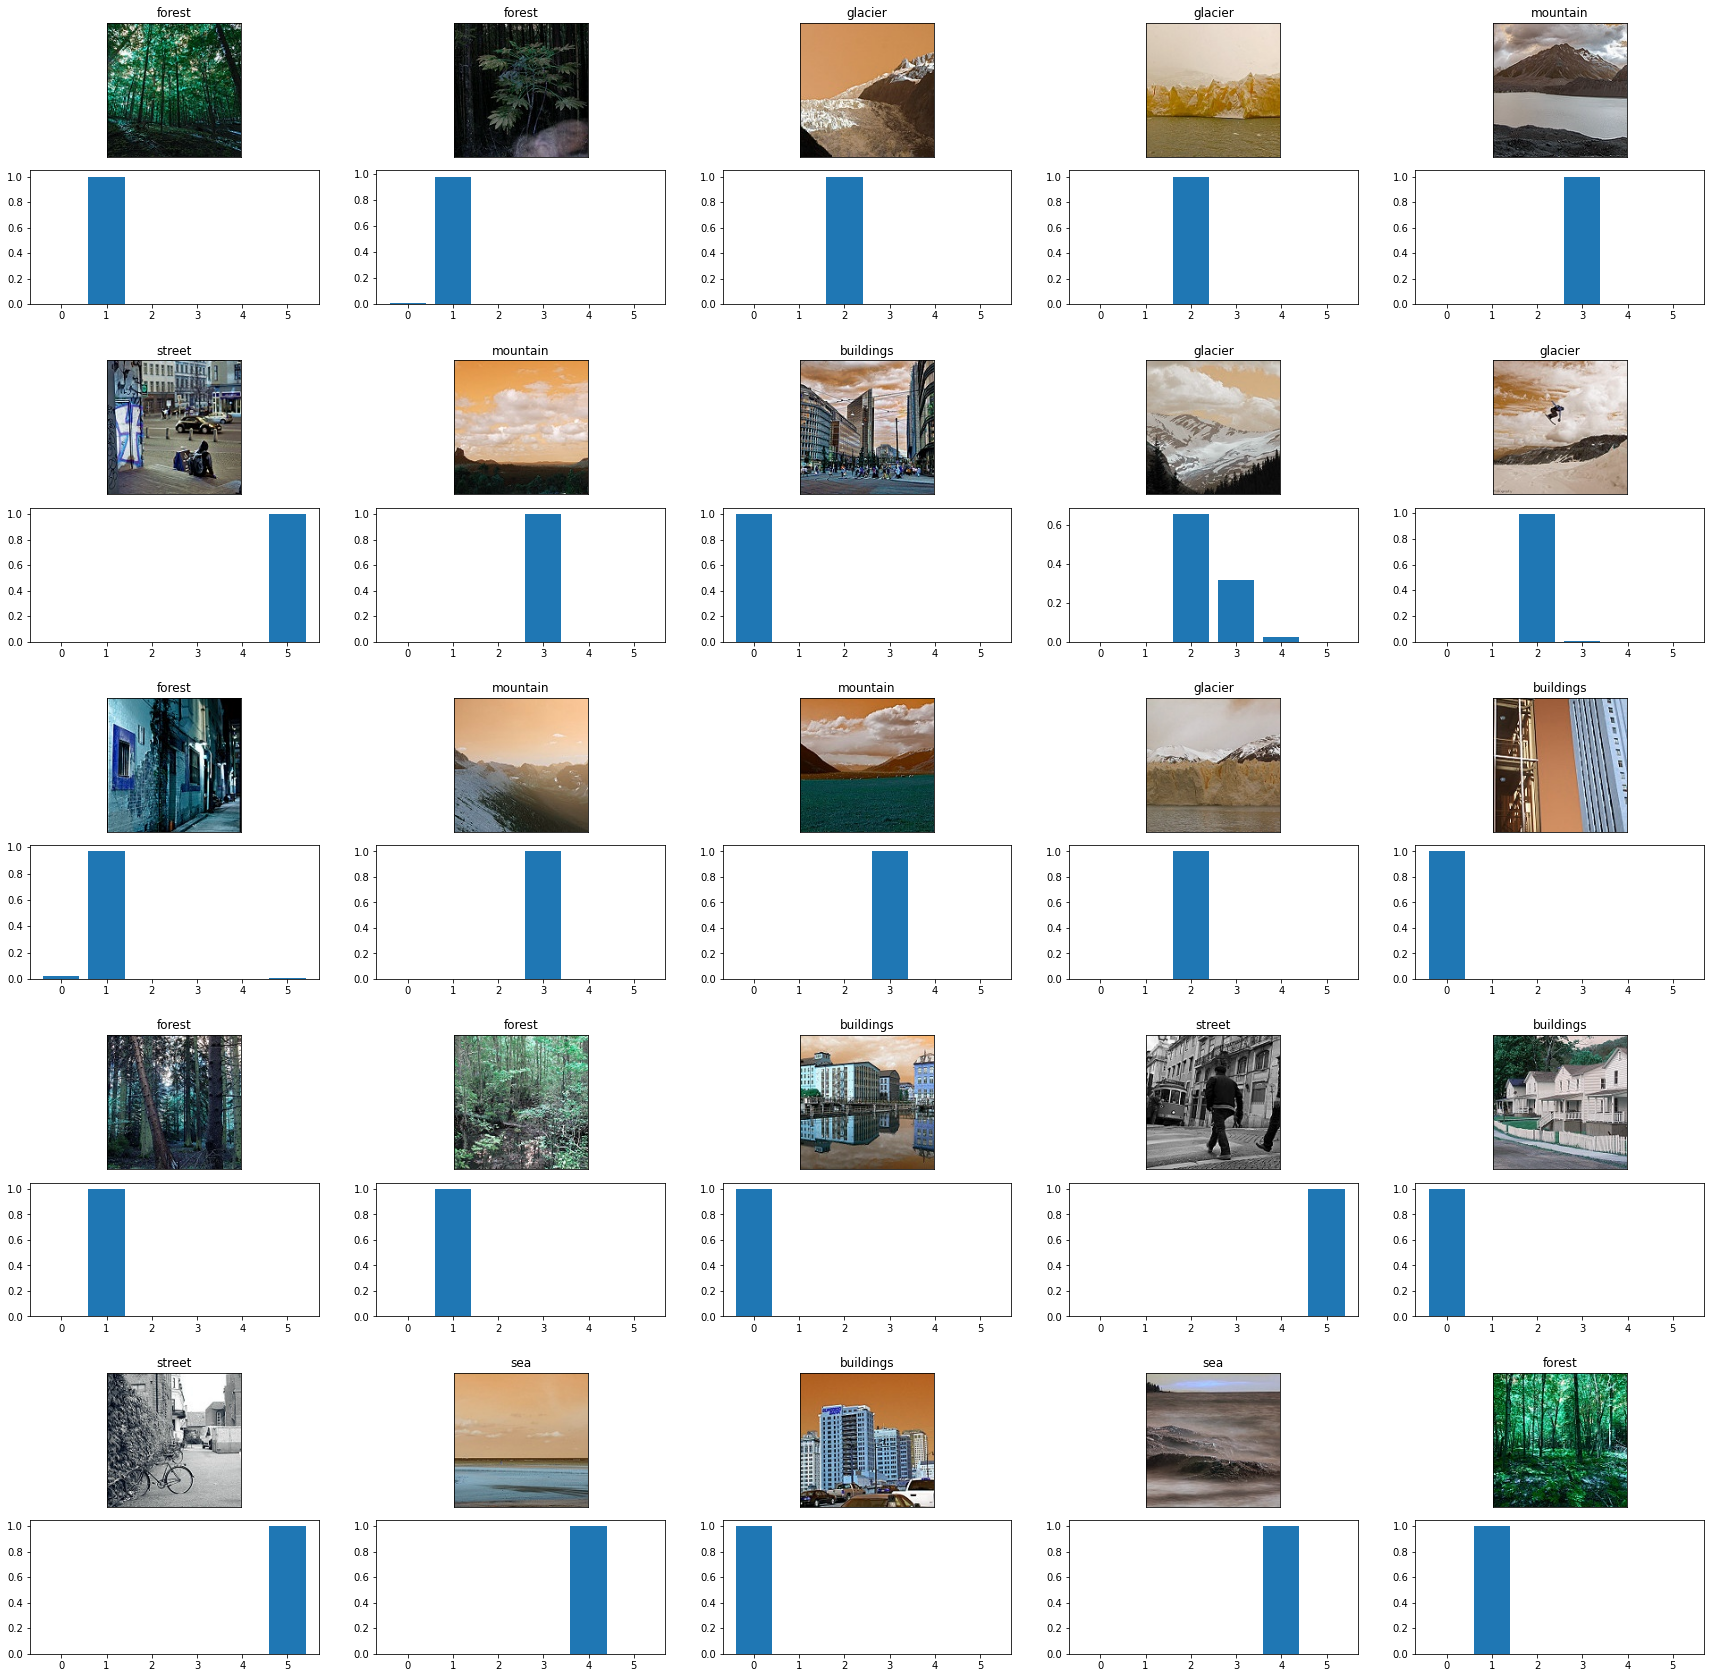

In [29]:
# visualize the predicted classes along with the images.
fig = plt.figure(figsize=(30, 30))
outer = gridspec.GridSpec(5, 5, wspace=0.2, hspace=0.2)

for i in range(25):
    inner = gridspec.GridSpecFromSubplotSpec(2, 1,subplot_spec=outer[i], wspace=0.1, hspace=0.1)
    rnd_number = randint(0,len(pred_images))
    pred_image = np.array([pred_images[rnd_number]])
    pred_class = get_classlabel(model.predict_classes(pred_image)[0])
    # print(pred_class)
    pred_prob = model.predict(pred_image).reshape(6)
    # print(pred_prob)
    for j in range(2):
        if (j%2) == 0:
            ax = plt.Subplot(fig, inner[j])
            ax.imshow(pred_image[0])
            ax.set_title(pred_class)
            ax.set_xticks([])
            ax.set_yticks([])
            fig.add_subplot(ax)
        else:
            ax = plt.Subplot(fig, inner[j])
            ax.bar([0,1,2,3,4,5],pred_prob)
            fig.add_subplot(ax)


fig.show()

**7. Confusion matrix of CNN model**

In [30]:
predictions = model.predict(test_images) 

In [31]:
pred_labels = np.argmax(predictions, axis = 1) # We take the highest probability

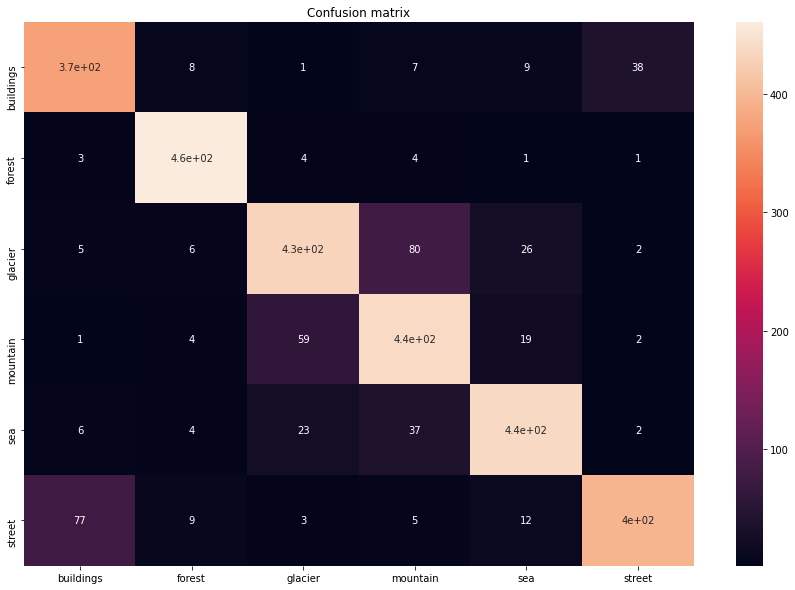

In [32]:
import sklearn.metrics as metrics
import seaborn as sn
CM = confusion_matrix(test_labels, pred_labels)
fig, ax = plt.subplots(figsize =(15,10))
ax = plt.axes()
sn.heatmap(CM, annot=True, 
           annot_kws={"size": 10}, 
           xticklabels=image_directories, 
           yticklabels=image_directories, ax = ax)
ax.set_title('Confusion matrix')
plt.show()

In [2]:
class_names = ['mountain', 'street', 'glacier', 'buildings', 'sea', 'forest']

def print_mislabeled_images(class_names, test_images, test_labels, pred_labels):
    """
        Print 25 examples of mislabeled images by the classifier, e.g when test_labels != pred_labels
    """
    BOO = (test_labels == pred_labels)
    mislabeled_indices = np.where(BOO == 0)
    mislabeled_images = test_images[mislabeled_indices]
    mislabeled_labels = pred_labels[mislabeled_indices]

    title = "Some examples of mislabeled images by the classifier:"
    display_examples(class_names,  mislabeled_images, mislabeled_labels)

**8. Transfer Learning model using VGG**



In [51]:
datagen = ImageDataGenerator(rescale=1/255.,
                            horizontal_flip=True,
                            width_shift_range=0.1,
                            height_shift_range=0.1)

test_datagen = ImageDataGenerator(rescale=1/255.)

In [52]:
#defining the data generators
from tensorflow.keras.preprocessing.image import ImageDataGenerator

d_input_shape = (150,150)
batch_size = 16
traingen = datagen.flow_from_directory('./seg_train',
                                      target_size = d_input_shape,
                                      class_mode='categorical',
                                      batch_size=batch_size,
                                      shuffle=False)

testgen = test_datagen.flow_from_directory('./seg_test',
                                      target_size = d_input_shape,
                                      class_mode='categorical',
                                      batch_size=batch_size,
                                      shuffle=False)

Found 14034 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


In [64]:
model = Sequential()
L2 = tf.keras.regularizers.l2(0.001)
input_shape = (150,150,3)


model = tf.keras.applications.VGG19(include_top=False, input_shape=input_shape)
for layer in model.layers:
    layer.trainable=False
flat = Flatten()(model.layers[-1].output)
hidden1 = Dense(128,activation='relu')(flat)
output = Dense(6,activation='softmax')(hidden1)

model = Model(inputs=model.inputs, outputs=output)
model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0   

In [65]:
model.compile(loss = 'categorical_crossentropy', optimizer= optimizers.Adam(0.001), metrics=['accuracy'])

In [66]:
history = model.fit(traingen,
                   epochs=10,
                   validation_data = testgen, )

Epoch 1/10
878/878 [==============================] - 104s 118ms/step - loss: 1.3438 - accuracy: 0.5733 - val_loss: 0.4440 - val_accuracy: 0.8393
Epoch 2/10
878/878 [==============================] - 93s 106ms/step - loss: 0.5176 - accuracy: 0.8024 - val_loss: 0.3938 - val_accuracy: 0.8540
Epoch 3/10
878/878 [==============================] - 94s 107ms/step - loss: 0.4460 - accuracy: 0.8300 - val_loss: 0.4900 - val_accuracy: 0.8113
Epoch 4/10
878/878 [==============================] - 94s 107ms/step - loss: 0.4076 - accuracy: 0.8467 - val_loss: 0.3648 - val_accuracy: 0.8630
Epoch 5/10
878/878 [==============================] - 94s 106ms/step - loss: 0.4063 - accuracy: 0.8433 - val_loss: 0.4041 - val_accuracy: 0.8520
Epoch 6/10
878/878 [==============================] - 93s 106ms/step - loss: 0.3882 - accuracy: 0.8542 - val_loss: 0.3793 - val_accuracy: 0.8527
Epoch 7/10
878/878 [==============================] - 94s 107ms/step - loss: 0.3842 - accuracy: 0.8499 - val_loss: 0.3896 - val_a

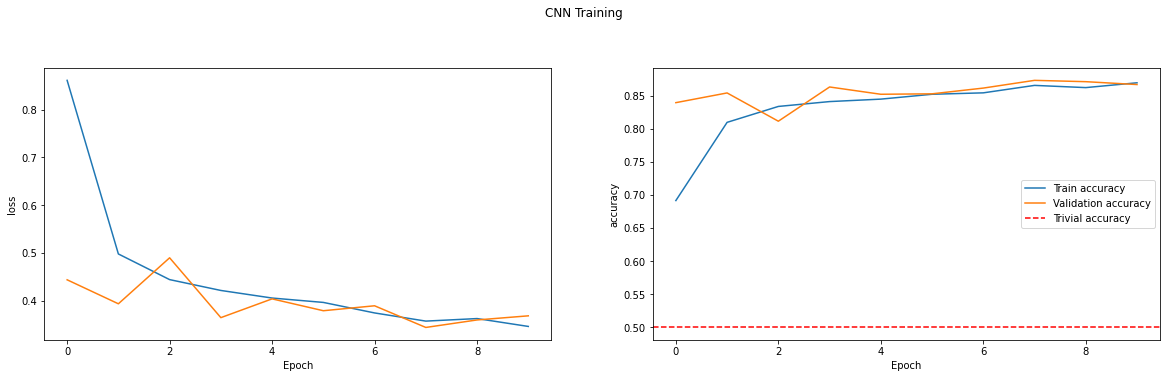

In [67]:
fig, ax = plt.subplots(1,2, figsize=(20,5))
for i, metric in enumerate(['loss', 'accuracy']): 
    ax[i].plot(history.history[metric], label=('Train '+metric))
    ax[i].plot(history.history['val_'+metric], label='Validation '+metric)
    if metric == 'accuracy': ax[i].axhline(0.5, c='r', ls='--', label='Trivial accuracy')
    ax[i].set_xlabel('Epoch')
    ax[i].set_ylabel(metric)
plt.suptitle('CNN Training', y=1.05)
plt.legend()

In [68]:
metric = model.evaluate(testgen)
print(f'The Loss of evluation is: {metric[0]}')
print(f'The Accuracy of evluation is: {metric[1]:.2%}')

188/188 [==============================] - 8s 44ms/step - loss: 0.3686 - accuracy: 0.8667
The Loss of evluation is: 0.36861076951026917
The Accuracy of evluation is: 86.67%
